# Installing kaggle

In [8]:
! pip install kaggle

# uploading json file

In [9]:
# configuring the path for the kaggle json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# importing Twitter Sentiment dataset

In [10]:
#API to fetch the Dataset from kaggle
!kaggle datasets download -d "kazanova/sentiment140"

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 85% 69.0M/80.9M [00:00<00:00, 723MB/s]
100% 80.9M/80.9M [00:00<00:00, 720MB/s]


In [11]:
#extracting the compressed dataset

from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


# importing the Dependencies

In [12]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer  #used to reduced word to root word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
#printing the stopwords in English
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

# Data Processing

In [15]:
#loadingthe data from csv file to pandas dataframe
twitter_data= pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

In [16]:
# checking the number of rows and columns
twitter_data.shape

(1599999, 6)

In [17]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [18]:
# naming the columns and reading the dataset again
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
twitter_data= pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names=column_names, encoding='ISO-8859-1')

In [19]:
twitter_data.shape

(1600000, 6)

In [20]:
# printing first 5 rows of the dataframe
twitter_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


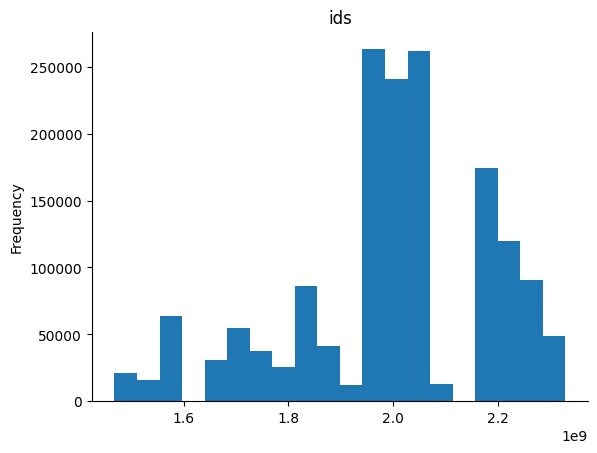

In [23]:
from matplotlib import pyplot as plt
twitter_data['ids'].plot(kind='hist', bins=20, title='ids')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [24]:
#counting the numbetr of missing value in the dataset
twitter_data.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


In [25]:
#checking the distribution of the target column
twitter_data['target'].value_counts()

,count
target,
0,800000
4,800000


# converting the label 4 to 1 for positive

In [26]:
twitter_data.replace({'target':{4:1}},inplace=True)

In [27]:
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


0 ----> Negative Tweet


1 ----> positive Tweet  

**Steming**

In [28]:
port_stem = PorterStemmer()

In [29]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content


In [31]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [32]:
twitter_data.head()


,target,ids,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [33]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [34]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


#Separating the data and label

In [35]:
x=twitter_data['stemmed_content'].values
y=twitter_data['target'].values

In [36]:
print(x)


['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [37]:
print(y)

[0 0 0 ... 1 1 1]


# Splitting the data to Training data and test data

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=2)

In [39]:
print(x.shape , X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [40]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [41]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


# converting the textual data to numerical data

In [42]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [43]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9453092 stored elements and shape (1280000, 461488)>
  Coords	Values
  (0, 436713)	0.27259876264838384
  (0, 354543)	0.3588091611460021
  (0, 185193)	0.5277679060576009
  (0, 109306)	0.3753708587402299
  (0, 235045)	0.41996827700291095
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 109306)	0.4591176413728317
  (2, 124484)	0.1892155960801415
  (2, 407301)	0.18709338684973031
  (2, 129411)	0.29074192727957143
  (2, 406399)	0.32105459490875526
  (2, 433560)	0.3296595898028565
  (2, 77929)	0.31284080750346344
  (2, 443430)	0.3348599670252845
  (2, 266729)	0.24123230668976975
  (2, 409143)	0.15169282335109835
  (2, 178061)	0.1619010109445149
  (2, 150715)	0.18803850583207948
  (2, 132311)	0.2028971570399794
  (2, 288470)	0.16786949597862733
  (3, 406399)	0.29029991238662284
  (3, 158711)	0.4456939372299574
  (3, 151770)	0.278559647704793
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 318303)	0.21254698865277744
  (12

In [44]:
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2289192 stored elements and shape (320000, 461488)>
  Coords	Values
  (0, 15110)	0.1719352837797837
  (0, 31168)	0.1624772418052177
  (0, 67828)	0.26800375270827315
  (0, 106069)	0.36555450010904555
  (0, 132364)	0.255254889555786
  (0, 138164)	0.23688292264071406
  (0, 171378)	0.2805816206356074
  (0, 271016)	0.45356623916588285
  (0, 279082)	0.17825180109103442
  (0, 388348)	0.2198507607206174
  (0, 398906)	0.34910438732642673
  (0, 409143)	0.3143047059807971
  (0, 420984)	0.17915624523539805
  (1, 6463)	0.30733520460524466
  (1, 15110)	0.211037449588008
  (1, 145393)	0.575262969264869
  (1, 217562)	0.40288153995289894
  (1, 256777)	0.28751585696559306
  (1, 348135)	0.4739279595416274
  (1, 366203)	0.24595562404108307
  (2, 22532)	0.3532582957477176
  (2, 34401)	0.37916255084357414
  (2, 89448)	0.36340369428387626
  (2, 183312)	0.5892069252021465
  (2, 256834)	0.2564939661498776
  :	:
  (319994, 443794)	0.2782185641032538


# Training the Machine Learning Model

## logistic Regression

In [45]:
Model = LogisticRegression(max_iter=1000)

In [46]:
Model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

Model Evalution

In [47]:
#Accuracy Score

In [48]:
#accuracy score on the Training data
X_train_prediction = Model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [49]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.79871953125


In [50]:
# Confusion Matrix on the training data
training_conf_matrix = confusion_matrix(Y_train, X_train_prediction)
print("Confusion Matrix (Training Data):\n", training_conf_matrix)

Confusion Matrix (Training Data):
 [[496481 143519]
 [114120 525880]]


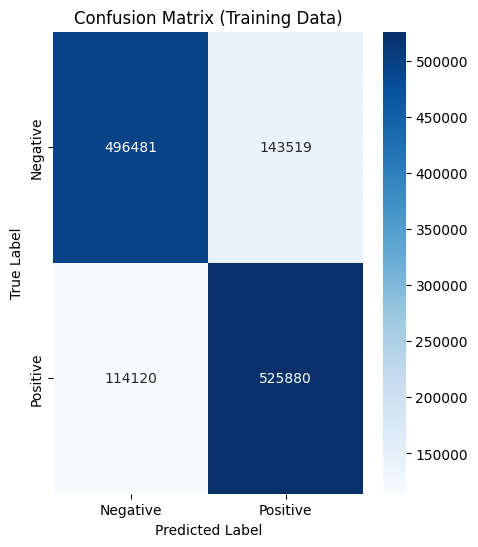

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix for training data
plt.figure(figsize=(5, 6))
sns.heatmap(training_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Training Data)')
plt.show()

In [57]:
#accuracy score on the Testing data
X_test_prediction = Model.predict(X_test)
testing_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [58]:
print('Accuracy score of the training data : ', testing_data_accuracy)

Accuracy score of the training data :  0.77668125


In [61]:
# Confusion Matrix on the testing data
testing_conf_matrix = confusion_matrix(Y_test, X_test_prediction)
print("Confusion Matrix (Testing Data):\n", training_conf_matrix)

Confusion Matrix (Testing Data):
 [[121246  38754]
 [ 32708 127292]]


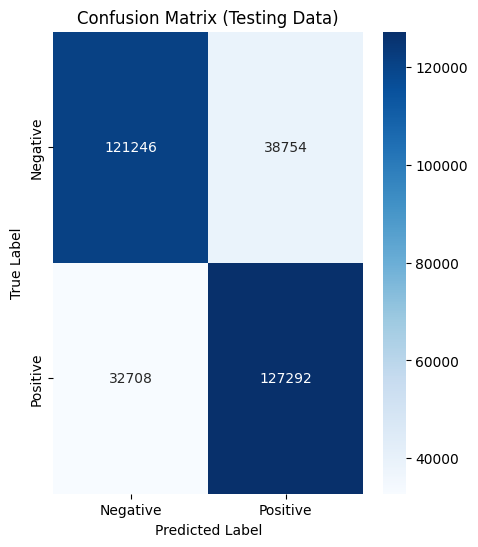

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix for training data
plt.figure(figsize=(5, 6))
sns.heatmap(testing_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Testing Data)')
plt.show()

# Model Accuracy 77.8

#Saving the model

In [63]:
import pickle

In [64]:
filename = 'trained_model.sav'
pickle.dump(Model, open(filename, 'wb'))

In [65]:
# loading the saved model
loaded_model = pickle.load(open('trained_model.sav', 'rb'))

In [71]:
X_new = X_test[100]
print(Y_test[100])

prediction =loaded_model.predict(X_new)
print(prediction)

if(prediction ==0):
  print('Negative tweet')
else:
  print('Positive tweet')

0
[0]
Negative tweet


In [74]:
X_new = X_test[200]
print(Y_test[200])

prediction =loaded_model.predict(X_new)
print(prediction)

if(prediction ==0):
  print('Negative tweet')
else:
  print('Positive tweet')

1
[1]
Positive tweet
